In [1]:
import os
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import dill
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import xarray as xr

In [2]:

data_directory = '/alzheimer/Roberto/Allen_Institute/Visual/'  # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

In [3]:
time_is_monotonic = pd.read_csv("/scratch/Roberto/Dropbox/temp/time_is_monotonic")
with open("/alzheimer/Roberto/temp/noise_artifact.pkl", 'rb') as f:
    noise_artifact = dill.load(f)
lfp_identity = pd.read_csv("/scratch/Roberto/Dropbox/temp/lfp_identity")

## Time non monotonic

#### Time doesn't monotonically increase in one probe

In [4]:
time_is_monotonic

,probe_id,non monotonic
0,810755797,False
1,810755801,False
2,810755805,False
3,810755807,False
4,810755803,False
...,...,...
320,848037570,False
321,848037572,False
322,848037578,False
323,848037576,False


In [5]:
time_is_monotonic[time_is_monotonic["non monotonic"]==True]

,probe_id,non monotonic
43,769325786,True


In [8]:
# from session
probes = cache.get_probes()
session_id  = probes.loc[time_is_monotonic[time_is_monotonic["non monotonic"]==True]["probe_id"]]["ecephys_session_id"].values[0]
session_id

743475441

In [7]:
session = cache.get_session_data(session_id)  

lfp = session.get_lfp(769325786)

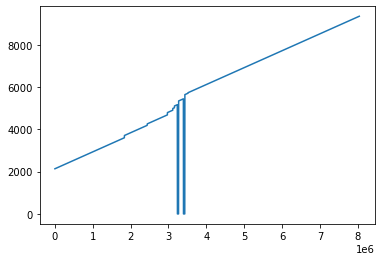

In [9]:
plt.plot(lfp.time)

## Noise artifacts

### weird flat lfp events see post here https://community.brain-map.org/t/invalid-times-missing-in-neuropixel-visual-coding-dataset/1362/10

In [10]:
out = []
for session in noise_artifact:
    for probe_id, noise_list in session:
        start = []
        stop = []
        for event in noise_list:
            start.append(event[0])
            stop.append(event[1])

        df = pd.DataFrame([start, stop], index=["Start (s)", "Stop (s)"]).T
        df["Probe_id"] = probe_id
        out.append(df)

In [11]:
noise_artifacts = pd.concat(out).reset_index(drop=True)
noise_artifacts

,Start (s),Stop (s),Probe_id
0,926.496725,926.535925,729445648
1,927.054343,927.060743,729445652
2,927.062343,927.072743,729445652
3,0.624769,9665.641738,729445656
4,0.625545,9665.623830,729445654
...,...,...,...
3932,349.023916,349.031115,841431758
3933,349.227114,349.232714,841431758
3934,3579.039602,3579.044402,848037570
3935,1417.692635,1417.699835,848037576


## In 2 sessions lfps are duplicated across different probes

#### channels belonging to different probes (therefore in different areas) show the same lfp signal

In [12]:
lfp_identity[lfp_identity["mistakes present"] == True]

,session_id,mistakes present
9,746083955,True
16,756029989,True


In [13]:
# sample from session 746083955, time is in samples! We have the first 1000 samples of the lfps 
with open('/scratch/Roberto/Dropbox/temp/lfp_sample.pkl', 'rb') as f:
    lfp_sample, channels = dill.load(f)

In [14]:
lfp_sample = xr.open_dataarray("/scratch/Roberto/Dropbox/temp/sample_lfp_session_746083955.nc")

In [15]:
lfp_sample

<xarray.DataArray '760647913' (time: 1000, channel: 383)>
[383000 values with dtype=float32]
Coordinates:
  * time               (time) int32 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
    parent_area        (channel) object ...
    area               (channel) object ...
    area_orig          (channel) object ...
  * channel            (channel) int32 849734700 849734708 ... 849739836
    vertical_position  (channel) int32 ...

In [16]:
errors = []
for column in lfp_sample.T:
    if np.sum(np.equal(column, lfp_sample)) > 2000:  #then it is an error
        errors.append(lfp_sample[:,np.sum(np.equal(column, lfp_sample), axis=0)==1000] )


First couple of duplicates belong to channels[849734700 849739452]


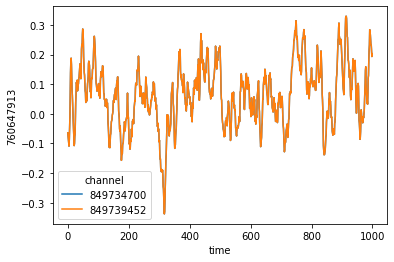

In [19]:
# error is a list of xarrays that contains a couple of duplicated lfps from different channels, this is the first duplicate
errors[0].plot.line(x="time")
print(f"First couple of duplicates belong to channels{errors[0].channel.values}")